In [1]:
import datetime
import duckdb
import numpy as np
import pandas as pd
import seaborn
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

# Load Dataset

In [2]:
dataset = 'sp500_2022.db'

# what stock is being targeted?
target = 'F'

# load the training data
with duckdb.connect(dataset, read_only=True) as con:
    df = con.sql("SELECT * FROM stocks ORDER BY stock, date").df()

# only keep stocks that exist for the entire range
all_dates = df.date.unique()
stocks = {}

# map each stock to a list of dates
for i, row in df.iterrows():
    stocks.setdefault(row.stock, []).append(row.date)

# filter all stocks that don't exist for all dates
for stock, dates in stocks.items():
    if len(dates) < len(all_dates):
        df = df[df.stock != stock]

# calculate the percent change for the day
df['pct'] = (df.close - df.open) / df.open

df

,stock,date,open,high,low,close,volume,trade_count,vwap,pct
0,A,2022-01-03,159.00,159.4400,153.9300,156.48,1855491.0,24320.0,155.916852,-0.015849
1,A,2022-01-04,155.49,155.6300,149.7000,151.19,2510184.0,34709.0,151.522046,-0.027655
2,A,2022-01-05,150.83,153.1000,148.5300,148.60,2966289.0,27423.0,149.705613,-0.014785
3,A,2022-01-06,148.85,149.9600,145.5800,149.12,2502203.0,34443.0,148.493000,0.001814
4,A,2022-01-07,149.12,149.7300,145.0900,145.15,2415233.0,28610.0,146.271401,-0.026623
...,...,...,...,...,...,...,...,...,...,...
125422,ZTS,2022-12-23,144.51,145.8920,143.5400,145.76,1017604.0,20025.0,145.236784,0.008650
125423,ZTS,2022-12-27,145.91,146.1474,143.5700,145.30,957871.0,19294.0,145.322438,-0.004181
125424,ZTS,2022-12-28,145.18,146.6400,143.7700,143.83,1443916.0,19669.0,144.409503,-0.009299
125425,ZTS,2022-12-29,145.20,148.5100,145.1378,148.15,1298851.0,21072.0,147.959023,0.020317


# Train on CPU or GPU?

In [3]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Define Model

The model attempts to use the stock list history to predict a single (target) stock's next day given the previous historical window of size N days.

The assumption is that many stocks are leading indicators for the target stock, including the target stock itself. By supplying the volume and closing (normalized across all stocks) of each stock as inputs over a course of N days, we train on what the close will be for the target stock on day N+1.

Using attention transformers add the hope that finding the leading indicators will be more accurate.

In [4]:
stock_features = ['pct']

# make sure all the selected stock features are present in the data
assert all([f in df.columns for f in stock_features])

class StockModel(nn.Module):

    def __init__(self, stocks, window_size):
        super().__init__()

        # number of input features being looked at (number of columns)
        self.input_size = len(stocks) * len(stock_features)

        # number of previous time stamps taken into account
        self.seq_len = window_size

        # number of features in the last hidden state (number of time steps to predict)
        self.hidden_size = self.input_size * 2 // 3

        # number of stacked RNN layers
        self.num_layers = window_size

        # build the network
        self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.lin = nn.Linear(self.hidden_size, self.input_size)
        self.act = nn.Tanh()
    
    def forward(self, x):
        out, (hn, cn) = self.rnn(x)
        #x = self.lin(out[:, -1, :])
        x = self.lin(hn[-1])
        #x = self.act(x)

        return x

# total number of input features
len(df.stock.unique()) * len(stock_features)

498

# Create Normalized Training Batches

In [5]:
stock_features = ['pct']

# create the date windows for all the batches
dates = list(df.date.unique())
days = 10
window_dates= [dates[i:i+days] for i in range(len(dates) - days - days)]

def create_window(dates):
    return df[df.date.isin(dates)][['stock', 'date', 'open', 'close', 'pct', 'volume']] \
        .sort_values(['stock', 'date'])

def get_inputs(batch):
    batch = batch.set_index('date').sort_values('stock')

    # all the unique days in the batch
    days = sorted(list(batch.index.unique()))

    # for each date, extract a tensor of the stock features
    input_features = [batch.loc[day][stock_features].values.flatten() for day in days]

    # convert the input features into a 2D tensor: (num_stocks, num_features)
    return np.asarray(input_features).astype(np.float32)

def get_prediction(batch, target, lag=1):
    last = batch[batch.stock == target].iloc[-1]

    # find all closes for the target stock lag days after the batch window
    pred_date = last.date + datetime.timedelta(days=lag)
    pred_row = df[(df.stock == target) & (df.date > pred_date)].sort_values('date').iloc[0]

    # did the stock go up or down
    pred = (pred_row.close - last.close) / last.close

    # negative prediction would indicate "don't buy" or "sell", positive is "buy" or "hold"
    return np.array(pred, dtype=np.float32)

# create all the windows
windows = [create_window(w) for w in window_dates]

# get the input features for all windows
inputs = [get_inputs(w) for w in windows]
inputs[0].shape

(10, 498)

# Train Model

In [6]:
stocks = sorted(list(df.stock.unique()))

# create the model
model = StockModel(stocks, len(windows[0].date.unique()))
model.to(device)

# get the target stock index
target_index = list.index(stocks, target)

# ensure the target stock is in the set of stocks
assert target_index >= 0

#loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss()
#loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# for every batch, get the prediction
predictions = [get_prediction(w, target) for w in windows]
saved_outputs = []

def train_epoch(batch_size=5):
    running_loss = 0
    ixs = np.arange(len(windows))

    # shuffle the indices
    np.random.shuffle(ixs)

    # create training batches of the indices
    batches = np.array_split(ixs, len(ixs) // batch_size)

    # train each batch
    for batch in batches[:len(batches) // 2]:
        optimizer.zero_grad()

        # setup inputs and prediction vectors
        x = torch.as_tensor(np.array([inputs[i] for i in batch])).to(device)
        y = torch.as_tensor(np.array([predictions[i] for i in batch])).to(device)

        # make a prediction
        outputs = model(x)
        #print(outputs)
        
        # get the target stock output
        target_output = outputs[:, target_index]

        #print(target_output.shape)
        #print(y.shape)

        # compute the loss and gradients
        loss = loss_fn(target_output, y)

        # backprop
        loss.backward()
        optimizer.step()

        # gather data and report
        running_loss += loss.sum().item()

        saved_outputs.append(target_output.detach())
    
    # report the loss at this step
    return running_loss

  0%|          | 0/20 [00:00<?, ?it/s]

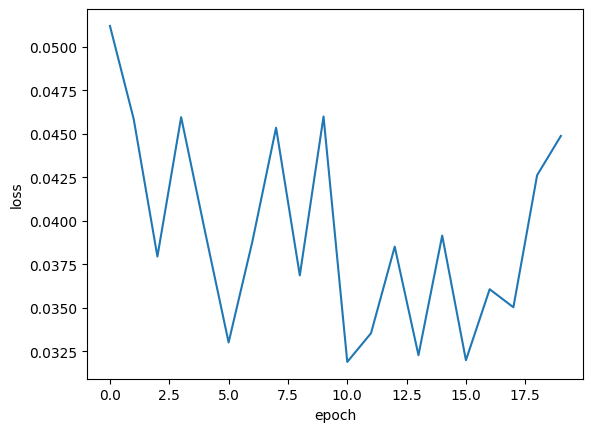

In [7]:
def train(num_epochs=20, batch_size=5):
    loss = [(i, train_epoch(batch_size)) for i in tqdm(range(num_epochs))]
    loss_df = pd.DataFrame(loss, columns=['epoch', 'loss'])
    
    # plot the loss
    seaborn.lineplot(loss_df, x='epoch', y='loss')

# continue training
train(20, 5)

# Save the Model

In [55]:
model_script = torch.jit.script(model)
model_script.save(f'model_{target}.pt')